In [1]:
%pylab inline
from __future__ import print_function, division

import os 
import numpy as np

# Astropy
from astropy.io import fits
from astropy.table import Table, Column, vstack, join

# GalSim 
import galsim

# astroML
from astroML.plotting import hist

# Matplotlib 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# from astroML.plotting import hist
# plt.ioff()

# Color map 
from palettable.colorbrewer.sequential import Oranges_4, Blues_5
ORG4 = Oranges_4.mpl_colormap
BLU5 = Blues_5.mpl_colormap

# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 1.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 1.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 1.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['legend.numpoints'] = 1
rc('axes', linewidth=2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
pixScale = 0.03    # "/pixel 
zeroPoint = 25.94  # mag

In [3]:
def toColorArr(data, bottom=None, top=None):
    """ 
    Convert a data array to "color array" (between 0 and 1). 
    
    Parameters:
        bottom, top  : 
    """
    if top is not None:
        data[data >= top] = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / 
            (np.nanmax(data) - np.nanmin(data))) * 255.0


def toSizeArr(data, bottom=None, top=None, maxSize=40):
    """ 
    Convert a data array to "size array". 
    
    Parameters:
        bottom, top  : 
    """
    if top is not None:
        data[data >= top] = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / 
            (np.nanmax(data) - np.nanmin(data))) * maxSize


def songPlotSetup(ax):
    """Setup the format of the figure."""
    # Axes setup
    #  Minor Ticks on 
    ax.minorticks_on()
    #  Axes Thickness
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(3.5)
    #  Tick Label Size 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    
    #  Tick Length and Width
    ax.tick_params('both', length=10, width=3.0, which='major')
    ax.tick_params('both', length=6, width=2.5, which='minor')
    
    return ax


def simpleScatter(tableUse, colName1, colName2, sample1=None, 
                  colColor='b_a', colSize='sersic_n', 
                  cmap=ORG4, maxSize=350, alpha=0.8, 
                  table2=None, sample2=None, cmap2=BLU5):
    #---------------------------------------------------------#
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
    ax1 = fig.add_subplot(111)
    # Formatting 
    ax1 = songPlotSetup(ax1)

    # RedMapper 
    if sample1 is None: 
        sample1 = 'Sample\ 1'
    ax1.scatter(tableUse[colName1], 
                tableUse[colName2], 
                c=toColorArr(tableUse[colColor]), 
                s=toSizeArr(tableUse[colSize], maxSize=maxSize), 
                alpha=alpha, cmap=cmap, label=sample1)

    # Label
    ax1.set_xlabel('$\mathrm{%s}$' % colName1, size=36)
    ax1.set_ylabel('$\mathrm{%s}$' % colName2, size=36)

    # Axis limits
    xmin, xmax = np.nanmin(tableUse[colName1]), np.nanmax(tableUse[colName1])
    ymin, ymax = np.nanmin(tableUse[colName2]), np.nanmax(tableUse[colName2])
    xmargin, ymargin = ((xmax - xmin) / 8.5), ((ymax - ymin) / 8.5)

    ax1.set_xlim(xmin-xmargin, xmax+xmargin)
    ax1.set_ylim(ymin-ymargin, ymax+ymargin)
    
    # Secondary sample ? 
    if table2 is not None: 
        if sample2 is None: 
            sample2 = 'Sample\ 2'
        ax1.scatter(table2[colName1], 
                    table2[colName2], 
                    c=toColorArr(table2[colColor]), 
                    s=toSizeArr(table2[colSize], maxSize=maxSize), 
                    alpha=alpha, cmap=cmap2, label=sample2)
    # Legend
    l_handles, l_labels = ax1.get_legend_handles_labels()
    ax1.legend(l_handles, l_labels, loc=(0.05, 0.85),
               shadow=True, fancybox=True, 
               numpoints=1, fontsize=26, scatterpoints=1, 
               markerscale=1.8, borderpad=0.2, handletextpad=0.1)
    #---------------------------------------------------------#
    
    return fig


def simpleHist(tableUse, colName, sample1=None, bins='knuth',
               alpha=0.5, table2=None, sample2=None, 
               showLegend=True, useLog=False):
    #---------------------------------------------------------#
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
    ax1 = fig.add_subplot(111)
    # Formatting 
    ax1 = songPlotSetup(ax1)

    # RedMapper 
    if sample1 is None: 
        sample1 = 'Sample\ 1'
        
    if useLog:
        hist(np.log10(tableUse[colName]), bins=bins, histtype='stepfilled',
             color='b', alpha=alpha, normed=True, 
             label=sample1, ax=ax1)
    else:
        hist(tableUse[colName], bins=bins, histtype='stepfilled',
             color='b', alpha=alpha, normed=True, 
             label=sample1, ax=ax1)

    # Label
    colnameUse = colName.replace('_', '\_')
    if useLog: 
        ax1.set_xlabel('$\log\ \mathrm{%s}$' % colnameUse, size=36)
    else: 
        ax1.set_xlabel('$\mathrm{%s}$' % colnameUse, size=36)

    ax1.set_ylabel('$\mathrm{\#}$', size=36)
    
    # Secondary sample ? 
    if table2 is not None: 
        if sample2 is None: 
            sample2 = 'Sample\ 2'
        if useLog:
            hist(np.log10(table2[colName]), bins=bins, histtype='step',
                 color='orange', normed=True, label=sample2, ax=ax1, 
                 linewidth=4.5)
        else:
            hist(table2[colName], bins=bins, histtype='step',
                 color='orange', normed=True, label=sample2, ax=ax1, 
                 linewidth=4.5)
        
    # Legend
    if showLegend:
        l_handles, l_labels = ax1.get_legend_handles_labels()
        ax1.legend(l_handles, l_labels, loc=(0.05, 0.84),
                   shadow=True, fancybox=True, 
                   numpoints=1, fontsize=26, scatterpoints=1, 
                   markerscale=1.8, borderpad=0.2, handletextpad=0.1)
    #---------------------------------------------------------#
    
    return fig

# Using galsim.COSMOSCatalog() -- Marginal Cut 

In [36]:
cosCat = galsim.COSMOSCatalog(exclusion_level='marginal')

print(cosCat.nobjects)

indexUse = cosCat.orig_index
paramCat = cosCat.param_cat
objectUse = paramCat[indexUse]

## Also exclude the one with no useful Sersic flux (1 object)
objectUse = objectUse[objectUse['flux'][:,0] > 0.0]
print(len(objectUse))

81499
81498


In [37]:
col1 = fits.Column(name='ID', format='J', array=objectUse['IDENT'])
col2 = fits.Column(name='mag_auto', format='D', array=objectUse['mag_auto'])
col3 = fits.Column(name='viable_sersic', format='I', array=objectUse['viable_sersic'])
col4 = fits.Column(name='flux', format='D', array=objectUse['flux'][:,0])
col5 = fits.Column(name='mag', format='D', array=(-2.5 * np.log10(objectUse['flux'][:,0]) + zeroPoint))
col6 = fits.Column(name='sersic_n', format='D', array=objectUse['sersicfit'][:,2])
col7 = fits.Column(name='reff', format='D', array=(objectUse['sersicfit'][:,1] * pixScale))
col8 = fits.Column(name='b_a', format='D', array=objectUse['sersicfit'][:,3])
col9 = fits.Column(name='theta', format='D', array=(objectUse['sersicfit'][:,7] * 180.0 / np.pi))
col10 = fits.Column(name='fit_mad_s', format='D', array=objectUse['fit_mad_s'])
col11 = fits.Column(name='use_bulgefit', format='I', array=objectUse['use_bulgefit'])
col12 = fits.Column(name='flux_radius', format='D', array=objectUse['flux_radius'])

cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7, col8, col9, col10, col11, col12])
tbhdu = fits.BinTableHDU.from_columns(cols)

tbhdu.writeto('cosmos_mag25.2_galsim_marginal.fits', clobber=True)

# Using galsim.COSMOSCatalog() -- None Cut 

In [10]:
cosCatNone = galsim.COSMOSCatalog(exclusion_level='none')

print(cosCatNone.nobjects)

indexUseNone= cosCatNone.orig_index
paramCatNone = cosCatNone.param_cat
objectUseNone = paramCatNone[indexUseNone]

## Also exclude the one with no useful Sersic flux (1 object)
objectUseNone = objectUseNone[objectUseNone['flux'][:,0] > 0.0]
print(len(objectUseNone))

87798
87766


In [11]:
col1 = fits.Column(name='ID', format='J', array=objectUseNone['IDENT'])
col2 = fits.Column(name='mag_auto', format='D', array=objectUseNone['mag_auto'])
col3 = fits.Column(name='viable_sersic', format='I', array=objectUseNone['viable_sersic'])
col4 = fits.Column(name='flux', format='D', array=objectUseNone['flux'][:,0])
col5 = fits.Column(name='mag', format='D', array=(-2.5 * np.log10(objectUseNone['flux'][:,0]) + zeroPoint))
col6 = fits.Column(name='sersic_n', format='D', array=objectUseNone['sersicfit'][:,2])
col7 = fits.Column(name='reff', format='D', array=(objectUseNone['sersicfit'][:,1] * pixScale))
col8 = fits.Column(name='b_a', format='D', array=objectUseNone['sersicfit'][:,3])
col9 = fits.Column(name='theta', format='D', array=(objectUseNone['sersicfit'][:,7] * 180.0 / np.pi))
col10 = fits.Column(name='fit_mad_s', format='D', array=objectUseNone['fit_mad_s'])
col11 = fits.Column(name='use_bulgefit', format='I', array=objectUseNone['use_bulgefit'])
col12 = fits.Column(name='flux_radius', format='D', array=objectUseNone['flux_radius'])

cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7, col8, col9, col10, col11, col12])
tbhdu = fits.BinTableHDU.from_columns(cols)

tbhdu.writeto('cosmos_mag25.2_galsim_none.fits', clobber=True)

# Using galsim.COSMOSCatalog() -- None Cut with Wegiht

In [33]:
cosCatWeight = galsim.COSMOSCatalog(exclusion_level='none')
cosCatReal = galsim.RealGalaxyCatalog()

indexUseWeight= cosCatWeight.orig_index

weights = cosCatReal.weight[indexUseWeight]

print(cosCatWeight.nobjects)

paramCatWeight = cosCatWeight.param_cat
objectUseWeight = paramCatWeight[indexUseWeight]

ud = galsim.UniformDeviate()

objectSelect = objectUseWeight[np.asarray([True if ww > ud() else False for ww in weights])]
print(len(objectSelect))

87798
54317


In [34]:
col1 = fits.Column(name='ID', format='J', array=objectSelect['IDENT'])
col2 = fits.Column(name='mag_auto', format='D', array=objectSelect['mag_auto'])
col3 = fits.Column(name='viable_sersic', format='I', array=objectSelect['viable_sersic'])
col4 = fits.Column(name='flux', format='D', array=objectSelect['flux'][:,0])
col5 = fits.Column(name='mag', format='D', array=(-2.5 * np.log10(objectSelect['flux'][:,0]) + zeroPoint))
col6 = fits.Column(name='sersic_n', format='D', array=objectSelect['sersicfit'][:,2])
col7 = fits.Column(name='reff', format='D', array=(objectSelect['sersicfit'][:,1] * pixScale))
col8 = fits.Column(name='b_a', format='D', array=objectSelect['sersicfit'][:,3])
col9 = fits.Column(name='theta', format='D', array=(objectSelect['sersicfit'][:,7] * 180.0 / np.pi))
col10 = fits.Column(name='fit_mad_s', format='D', array=objectSelect['fit_mad_s'])
col11 = fits.Column(name='use_bulgefit', format='I', array=objectSelect['use_bulgefit'])
col12 = fits.Column(name='flux_radius', format='D', array=objectSelect['flux_radius'])

cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7, col8, col9, col10, col11, col12])
tbhdu = fits.BinTableHDU.from_columns(cols)

tbhdu.writeto('cosmos_mag25.2_galsim_noneWeight.fits', clobber=True)

/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


# Compare with Song Huang's cut

* The major difference is the magnitude cut. 

In [133]:
# The catalog organized by Claire 
catClaire = Table.read('cosmos_mag25.2_claire.fits', format='fits')
print("# Claire's catalog: %d objects" % len(catClaire))

# Song Huang's cut 
catShuang = Table.read('cosmos_mag25.2_shuang.fits', format='fits')
print("# Song Huang's cut: %d objects" % len(catShuang))

# The GalSim default catalog
catGalsim = Table.read('cosmos_mag25.2_galsim.fits', format='fits')
print("# GalSim's marginal cut: %d objects" % len(catGalsim))

# Claire's catalog: 86440 objects
# Song Huang's cut: 58717 objects
# GalSim's marginal cut: 81483 objects


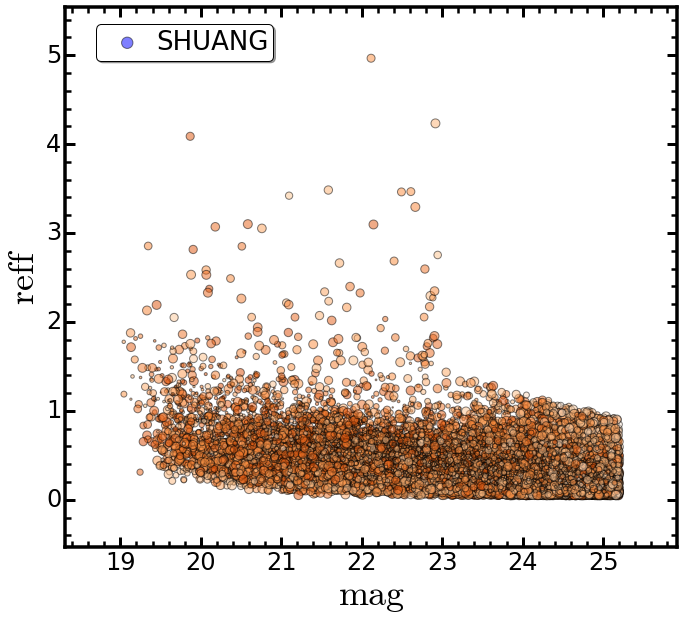

In [85]:
fig1 = simpleScatter(catShuang, 'mag', 'reff', sample1='SHUANG', 
                     maxSize=80, alpha=0.5)

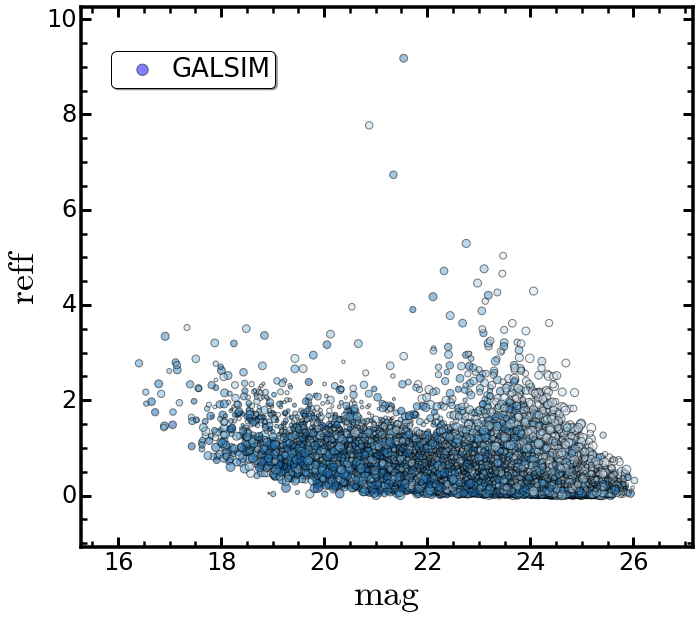

In [134]:
fig2 = simpleScatter(catGalsim, 'mag', 'reff', sample1='GALSIM', 
                     maxSize=80, alpha=0.5, cmap=BLU5)

23409


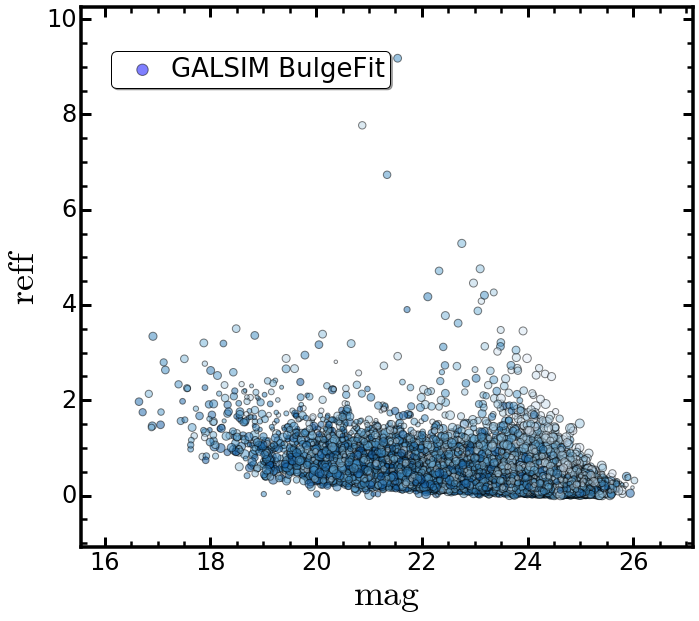

In [140]:
bpdGalsim = catGalsim[catGalsim['use_bulgefit'] == 1]
print(len(bpdGalsim))

fig3 = simpleScatter(bpdGalsim, 'mag', 'reff', sample1='GALSIM BulgeFit', 
                     maxSize=80, alpha=0.5, cmap=BLU5)

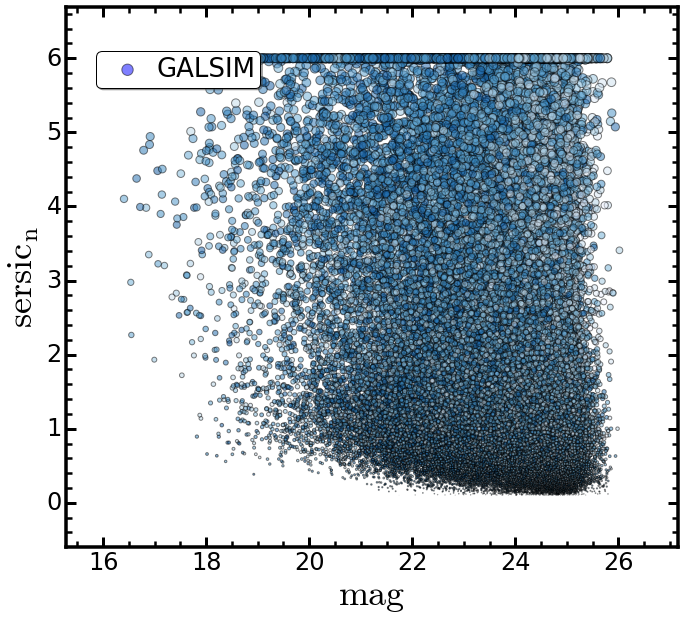

In [143]:
fig4 = simpleScatter(catGalsim, 'mag', 'sersic_n', sample1='GALSIM', 
                     maxSize=80, alpha=0.5, cmap=BLU5)

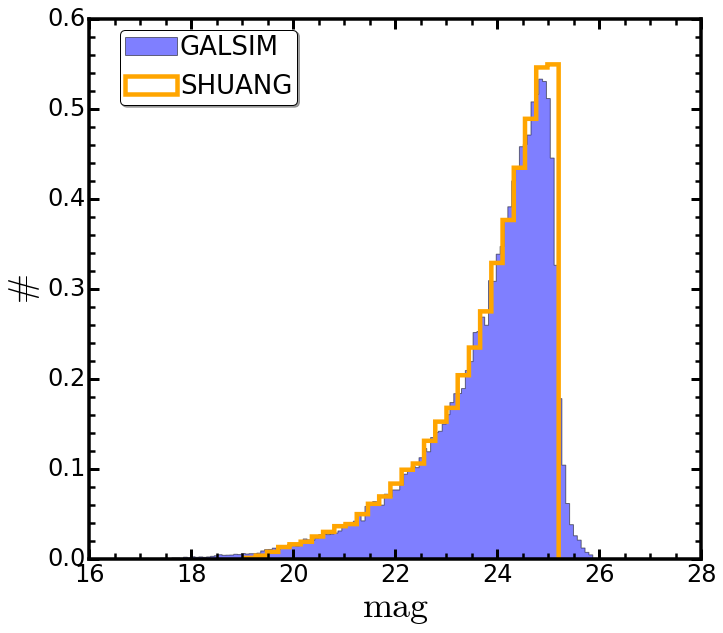

In [109]:
hist1 = simpleHist(catGalsim, 'mag', sample1='GALSIM', bins='knuth',
                   alpha=0.5, table2=catShuang, sample2='SHUANG')

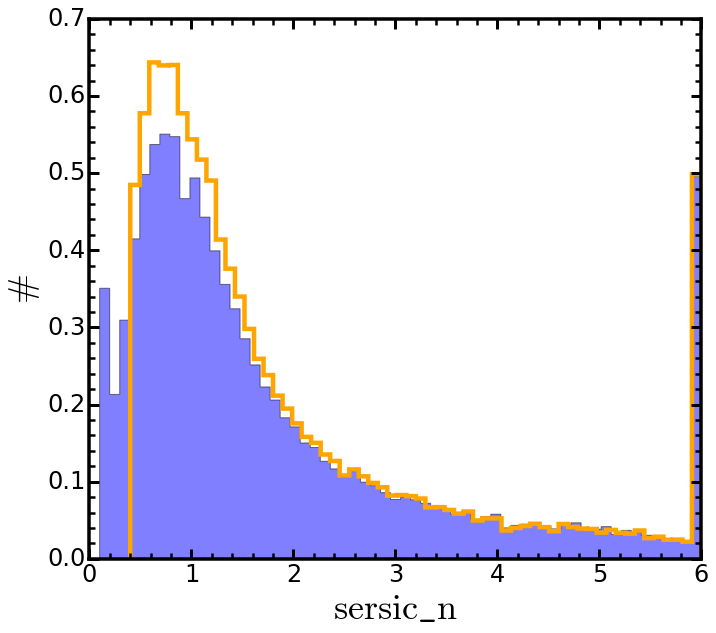

In [116]:
hist2 = simpleHist(catGalsim, 'sersic_n', sample1='GALSIM', bins=60,
                   alpha=0.5, table2=catShuang, sample2='SHUANG', showLegend=False)

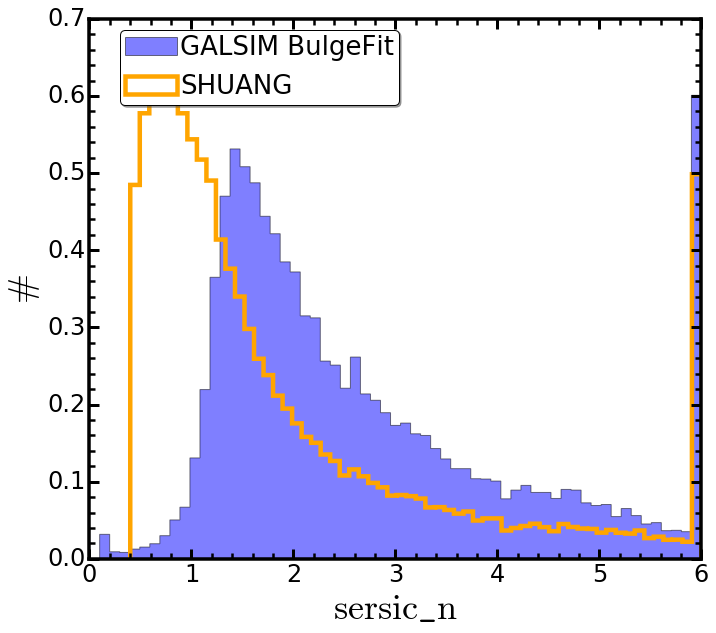

In [142]:
hist2b = simpleHist(bpdGalsim, 'sersic_n', sample1='GALSIM BulgeFit', bins=60,
                    alpha=0.5, table2=catShuang, sample2='SHUANG', showLegend=True)

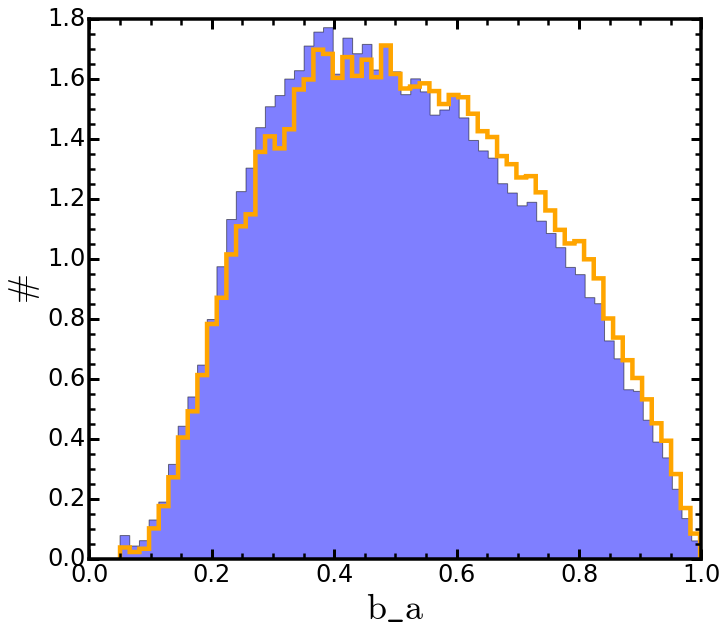

In [118]:
hist3 = simpleHist(catGalsim, 'b_a', sample1='GALSIM', bins=60,
                   alpha=0.5, table2=catShuang, sample2='SHUANG', showLegend=False)

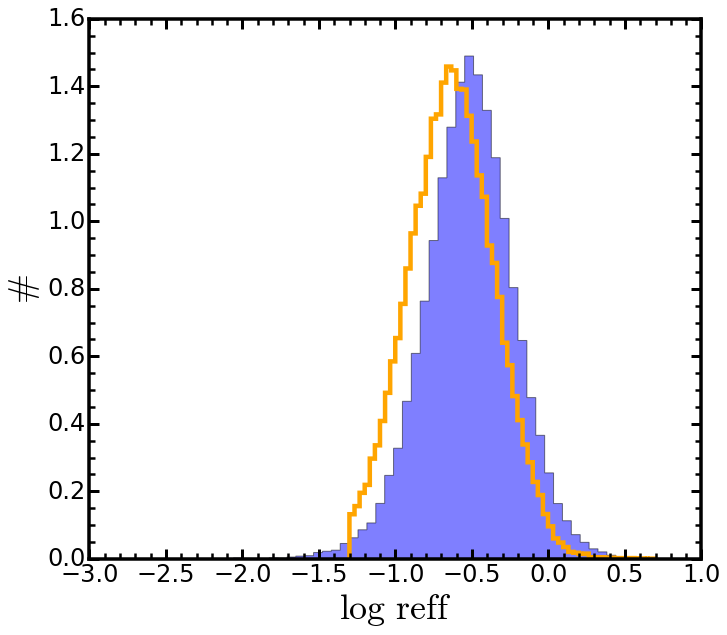

In [122]:
hist4 = simpleHist(catGalsim, 'reff', sample1='GALSIM', bins=60,
                   alpha=0.5, table2=catShuang, sample2='SHUANG', 
                   showLegend=False, useLog=True)